#**CELL 1 - Setup & Load Preprocessed Data**

In [1]:
# ============================================================================
# CELL 1: Setup & Load Preprocessed Data (PIPELINE B)
# ============================================================================

import pandas as pd
import numpy as np
from pathlib import Path
import json
import pickle
import time
import warnings
warnings.filterwarnings("ignore")

# Models
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

try:
    from xgboost import XGBRegressor
    HAS_XGB = True
except Exception:
    HAS_XGB = False

# Metrics + CV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

print("=" * 80)
print("IMPETUS MODELING B - INJURY RISK SCORE REGRESSION (PIPELINE B)")
print("=" * 80)
print()

# --------------------------------------------------------------------------
# CONFIG
# --------------------------------------------------------------------------
PIPELINE_KEY = "B"
TARGET_COL = "injury_risk_score"
META_COLS = ["user_id", "date", "experience_label"]

DATA_DIR = Path("data/synth_set_level_v2")
MODEL_DIR = Path("models")
VIZ_DIR = Path("visualizations")
MODEL_DIR.mkdir(exist_ok=True)
VIZ_DIR.mkdir(exist_ok=True)

train_path = DATA_DIR / "impetus_train_B.csv"
test_path  = DATA_DIR / "impetus_test_B.csv"

train_df = pd.read_csv(train_path, parse_dates=["date"])
test_df  = pd.read_csv(test_path,  parse_dates=["date"])

# Ordina temporalmente
train_df = train_df.sort_values("date").reset_index(drop=True)
test_df  = test_df.sort_values("date").reset_index(drop=True)

print(f"Train: {train_df.shape} | {train_df['date'].min().date()} -> {train_df['date'].max().date()}")
print(f"Test : {test_df.shape} | {test_df['date'].min().date()} -> {test_df['date'].max().date()}")
print()

# Load metadata
with open(MODEL_DIR / "impetus_feature_metadata.json", "r") as f:
    metadata = json.load(f)

feature_cols = metadata["pipelines"][PIPELINE_KEY]["feature_cols"]

# Guardrail: rimuovi meta + target
ban_cols = set(META_COLS + ["performance_score_0_10", "injury_risk_score"])
feature_cols = [c for c in feature_cols if c not in ban_cols]

print(f"Features (da metadata, filtrate): {len(feature_cols)}")
print()

# Prepare X, y
X_train = train_df[feature_cols].copy()
y_train = train_df[TARGET_COL].copy()
X_test  = test_df[feature_cols].copy()
y_test  = test_df[TARGET_COL].copy()

print("SHAPES:")
print(f"  X_train: {X_train.shape}")
print(f"  y_train: {y_train.shape}, range [{y_train.min():.2f}, {y_train.max():.2f}]")
print(f"  X_test : {X_test.shape}")
print(f"  y_test : {y_test.shape}, range [{y_test.min():.2f}, {y_test.max():.2f}]")
print()

print("TARGET STATISTICS:")
print(f"  Train mean: {y_train.mean():.2f}, std: {y_train.std():.2f}")
print(f"  Test  mean: {y_test.mean():.2f}, std: {y_test.std():.2f}")
print(f"  Distribution shift (mean abs diff): {abs(y_train.mean() - y_test.mean()):.2f}")
print()

# CV + grid shared
PARAM_GRID_RIDGE = {"alpha": [0.01, 0.1, 1.0, 10.0, 100.0]}
TSCV = TimeSeriesSplit(n_splits=5)


IMPETUS MODELING B - INJURY RISK SCORE REGRESSION (PIPELINE B)

Train: (68694, 39) | 2023-05-06 -> 2025-11-19
Test : (17131, 39) | 2025-11-20 -> 2026-02-08

Features (da metadata, filtrate): 35

SHAPES:
  X_train: (68694, 35)
  y_train: (68694,), range [0.00, 9.79]
  X_test : (17131, 35)
  y_test : (17131,), range [0.00, 8.86]

TARGET STATISTICS:
  Train mean: 1.48, std: 0.95
  Test  mean: 1.54, std: 1.11
  Distribution shift (mean abs diff): 0.06



In [2]:
# ============================================================================
# CELL 1A: Audit temporale - righe per mese
# ============================================================================

def month_counts(df, name):
    tmp = df.copy()
    tmp["month"] = tmp["date"].dt.to_period("M").astype(str)
    vc = tmp["month"].value_counts().sort_index()
    print(f"\n{name} - month counts (head/tail):")
    print(vc.head(6).to_string())
    if len(vc) > 12:
        print("...")
    print(vc.tail(6).to_string())

month_counts(train_df, "TRAIN_B")
month_counts(test_df, "TEST_B")

print("\nTrain max date:", train_df["date"].max())
print("Test  min date:", test_df["date"].min())
print("Gap days:", (test_df["date"].min() - train_df["date"].max()).days)
print()



TRAIN_B - month counts (head/tail):
month
2023-05     31
2023-06     96
2023-07    170
2023-08    252
2023-09    339
2023-10    453
...
month
2025-06    4079
2025-07    4388
2025-08    4657
2025-09    4905
2025-10    5456
2025-11    3633

TEST_B - month counts (head/tail):
month
2025-11    2172
2025-12    6421
2026-01    6776
2026-02    1762
month
2025-11    2172
2025-12    6421
2026-01    6776
2026-02    1762

Train max date: 2025-11-19 00:00:00
Test  min date: 2025-11-20 00:00:00
Gap days: 1



In [3]:
# ============================================================================
# CELL 1.5: Check NaN/Inf + dropna su feature+target (robusto)
# ============================================================================

def report_and_clean(df, feature_cols, target_col, name="df"):
    df = df.copy()
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    n_before = len(df)
    n_rows_with_nan = int(df[feature_cols + [target_col]].isna().any(axis=1).sum())

    print(f"[{name}] Rows before: {n_before:,}")
    print(f"[{name}] Rows with NaN (features/target): {n_rows_with_nan:,}")

    if n_rows_with_nan > 0:
        na_counts = df[feature_cols + [target_col]].isna().sum().sort_values(ascending=False)
        top = na_counts[na_counts > 0].head(20)
        print(f"[{name}] Top columns with NaN:")
        print(top.to_string())
    else:
        print(f"[{name}] No NaN in selected columns.")

    df_clean = df.dropna(subset=feature_cols + [target_col]).copy()
    n_after = len(df_clean)
    print(f"[{name}] Rows after dropna: {n_after:,} (dropped {n_before - n_after:,})\n")
    return df_clean

train_df = report_and_clean(train_df, feature_cols, TARGET_COL, name="train_df")
test_df  = report_and_clean(test_df,  feature_cols, TARGET_COL, name="test_df")

X_train = train_df[feature_cols].copy()
y_train = train_df[TARGET_COL].copy()
X_test  = test_df[feature_cols].copy()
y_test  = test_df[TARGET_COL].copy()

print("[CLEAN SHAPES]")
print("X_train:", X_train.shape, "| y_train:", y_train.shape)
print("X_test :", X_test.shape,  "| y_test :", y_test.shape)
print()


[train_df] Rows before: 68,694
[train_df] Rows with NaN (features/target): 0
[train_df] No NaN in selected columns.
[train_df] Rows after dropna: 68,694 (dropped 0)

[test_df] Rows before: 17,131
[test_df] Rows with NaN (features/target): 0
[test_df] No NaN in selected columns.
[test_df] Rows after dropna: 17,131 (dropped 0)

[CLEAN SHAPES]
X_train: (68694, 35) | y_train: (68694,)
X_test : (17131, 35) | y_test : (17131,)



In [4]:
# ============================================================================
# CELL 1B: Imbalance check robusto (zero vs quasi-zero)
# ============================================================================

ZERO_EPS = 1e-6

train_zeros = int((y_train == 0).sum())
test_zeros  = int((y_test == 0).sum())

train_near0 = int((y_train.abs() < ZERO_EPS).sum())
test_near0  = int((y_test.abs() < ZERO_EPS).sum())

print("TARGET IMBALANCE (risk=0):")
print(f"  Exact zeros           - Train: {train_zeros:,}/{len(y_train):,} ({train_zeros/len(y_train)*100:.1f}%)")
print(f"  Exact zeros           - Test : {test_zeros:,}/{len(y_test):,} ({test_zeros/len(y_test)*100:.1f}%)")
print(f"  Near-zeros(<{ZERO_EPS}) - Train: {train_near0:,}/{len(y_train):,} ({train_near0/len(y_train)*100:.1f}%)")
print(f"  Near-zeros(<{ZERO_EPS}) - Test : {test_near0:,}/{len(y_test):,} ({test_near0/len(y_test)*100:.1f}%)")
print()


TARGET IMBALANCE (risk=0):
  Exact zeros           - Train: 0/68,694 (0.0%)
  Exact zeros           - Test : 0/17,131 (0.0%)
  Near-zeros(<1e-06) - Train: 0/68,694 (0.0%)
  Near-zeros(<1e-06) - Test : 0/17,131 (0.0%)



#**CELL 2 - Ridge Regression (WITH Lag)**

In [5]:
# ============================================================================
# CELL 2: Ridge Regression (WITH Lag) - α Tuning (TimeSeriesSplit CV)
# ============================================================================

def regression_metrics(y_true, y_pred, mape_min_y=0.5):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # MAPE: sensibile a valori piccoli [web:289]
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-10))) * 100

    # MAPE masked (più interpretabile)
    mask = (y_true >= mape_min_y)
    mape_masked = np.mean(np.abs((y_true[mask] - y_pred[mask]) / (y_true[mask] + 1e-10))) * 100 if mask.any() else np.nan

    # sMAPE (più robusta vicino a 0) [web:296]
    smape = np.mean(2.0 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-10)) * 100

    return r2, mae, rmse, mape, mape_masked, smape

print("\n" + "=" * 80)
print("SECTION 1: WITH LAG FEATURES - MODELING")
print("=" * 80)
print("\nMODEL 1: RIDGE REGRESSION (L2 Regularization)")
print("-" * 80)

ridge = Ridge(random_state=42)
grid_search = GridSearchCV(ridge, PARAM_GRID_RIDGE, cv=TSCV, scoring="r2", n_jobs=-1)

t0 = time.time()
grid_search.fit(X_train, y_train)
train_time_ridge = time.time() - t0

best_ridge = grid_search.best_estimator_
best_alpha = grid_search.best_params_["alpha"]

print(f"Best α: {best_alpha} (TimeSeriesSplit CV)")
print(f"Training time: {train_time_ridge:.2f}s\n")

y_train_pred_ridge = best_ridge.predict(X_train)
y_test_pred_ridge  = best_ridge.predict(X_test)

(r2_train_ridge, mae_train_ridge, rmse_train_ridge,
 mape_train_ridge, mapeM_train_ridge, smape_train_ridge) = regression_metrics(y_train, y_train_pred_ridge)

(r2_test_ridge, mae_test_ridge, rmse_test_ridge,
 mape_test_ridge, mapeM_test_ridge, smape_test_ridge) = regression_metrics(y_test, y_test_pred_ridge)

gap_ridge = r2_train_ridge - r2_test_ridge

print("RESULTS:")
print(f"  R² Train: {r2_train_ridge:.4f}")
print(f"  R² Test : {r2_test_ridge:.4f}")
print(f"  Train-Test Gap: {gap_ridge:.4f}")
print(f"  MAE Test : {mae_test_ridge:.3f} (scala 0-10)")
print(f"  RMSE Test: {rmse_test_ridge:.3f}")
print(f"  MAPE Test: {mape_test_ridge:.1f}% (sensibile a valori piccoli)")
print(f"  MAPE Test (y>=0.5): {mapeM_test_ridge:.1f}%")
print(f"  sMAPE Test: {smape_test_ridge:.1f}%")



SECTION 1: WITH LAG FEATURES - MODELING

MODEL 1: RIDGE REGRESSION (L2 Regularization)
--------------------------------------------------------------------------------
Best α: 10.0 (TimeSeriesSplit CV)
Training time: 3.24s

RESULTS:
  R² Train: 0.9038
  R² Test : 0.8277
  Train-Test Gap: 0.0761
  MAE Test : 0.245 (scala 0-10)
  RMSE Test: 0.461
  MAPE Test: 138.9% (sensibile a valori piccoli)
  MAPE Test (y>=0.5): 17.7%
  sMAPE Test: 31.4%


#**CELL 3 - Decision Tree Regressor (WITH Lag)**

In [6]:
# ============================================================================
# CELL 3: Decision Tree Regressor (WITH Lag)
# ============================================================================

print("\n" + "=" * 80)
print("MODEL 2: DECISION TREE REGRESSOR")
print("-" * 80)

dt = DecisionTreeRegressor(max_depth=10, min_samples_split=50, random_state=42)

t0 = time.time()
dt.fit(X_train, y_train)
train_time_dt = time.time() - t0

y_train_pred_dt = dt.predict(X_train)
y_test_pred_dt  = dt.predict(X_test)

(r2_train_dt, mae_train_dt, rmse_train_dt,
 mape_train_dt, mapeM_train_dt, smape_train_dt) = regression_metrics(y_train, y_train_pred_dt)

(r2_test_dt, mae_test_dt, rmse_test_dt,
 mape_test_dt, mapeM_test_dt, smape_test_dt) = regression_metrics(y_test, y_test_pred_dt)

gap_dt = r2_train_dt - r2_test_dt

print(f"Training time: {train_time_dt:.2f}s\n")
print("RESULTS:")
print(f"  R² Train: {r2_train_dt:.4f}")
print(f"  R² Test : {r2_test_dt:.4f}")
print(f"  Train-Test Gap: {gap_dt:.4f}")
print(f"  MAE Test : {mae_test_dt:.3f}")
print(f"  RMSE Test: {rmse_test_dt:.3f}")
print(f"  sMAPE Test: {smape_test_dt:.1f}%")



MODEL 2: DECISION TREE REGRESSOR
--------------------------------------------------------------------------------
Training time: 5.00s

RESULTS:
  R² Train: 0.9997
  R² Test : 0.9996
  Train-Test Gap: 0.0001
  MAE Test : 0.005
  RMSE Test: 0.022
  sMAPE Test: 2.3%


#**CELL 4 - Random Forest Regressor (WITH Lag)**

In [7]:
# ============================================================================
# CELL 4: Random Forest Regressor (WITH Lag)
# ============================================================================

print("\n" + "=" * 80)
print("MODEL 3: RANDOM FOREST REGRESSOR")
print("-" * 80)

rf = RandomForestRegressor(
    n_estimators=100, max_depth=15, min_samples_split=20,
    random_state=42, n_jobs=-1
)

t0 = time.time()
rf.fit(X_train, y_train)
train_time_rf = time.time() - t0

y_train_pred_rf = rf.predict(X_train)
y_test_pred_rf  = rf.predict(X_test)

(r2_train_rf, mae_train_rf, rmse_train_rf,
 mape_train_rf, mapeM_train_rf, smape_train_rf) = regression_metrics(y_train, y_train_pred_rf)

(r2_test_rf, mae_test_rf, rmse_test_rf,
 mape_test_rf, mapeM_test_rf, smape_test_rf) = regression_metrics(y_test, y_test_pred_rf)

gap_rf = r2_train_rf - r2_test_rf

print(f"Training time: {train_time_rf:.2f}s\n")
print("RESULTS:")
print(f"  R² Train: {r2_train_rf:.4f}")
print(f"  R² Test : {r2_test_rf:.4f}")
print(f"  Train-Test Gap: {gap_rf:.4f}")
print(f"  MAE Test : {mae_test_rf:.3f}")
print(f"  RMSE Test: {rmse_test_rf:.3f}")
print(f"  sMAPE Test: {smape_test_rf:.1f}%")



MODEL 3: RANDOM FOREST REGRESSOR
--------------------------------------------------------------------------------
Training time: 256.67s

RESULTS:
  R² Train: 0.9999
  R² Test : 0.9999
  Train-Test Gap: 0.0000
  MAE Test : 0.001
  RMSE Test: 0.010
  sMAPE Test: 0.5%


#**CELL 5 - Gradient Boosting Regressor (WITH Lag)**

In [8]:
# ============================================================================
# CELL 5: Gradient Boosting Regressor (WITH Lag)
# ============================================================================

print("\n" + "=" * 80)
print("MODEL 4: GRADIENT BOOSTING REGRESSOR")
print("-" * 80)

gb = GradientBoostingRegressor(
    n_estimators=100, learning_rate=0.1, max_depth=5,
    min_samples_split=20, random_state=42
)

t0 = time.time()
gb.fit(X_train, y_train)
train_time_gb = time.time() - t0

y_train_pred_gb = gb.predict(X_train)
y_test_pred_gb  = gb.predict(X_test)

(r2_train_gb, mae_train_gb, rmse_train_gb,
 mape_train_gb, mapeM_train_gb, smape_train_gb) = regression_metrics(y_train, y_train_pred_gb)

(r2_test_gb, mae_test_gb, rmse_test_gb,
 mape_test_gb, mapeM_test_gb, smape_test_gb) = regression_metrics(y_test, y_test_pred_gb)

gap_gb = r2_train_gb - r2_test_gb

print(f"Training time: {train_time_gb:.2f}s\n")
print("RESULTS:")
print(f"  R² Train: {r2_train_gb:.4f}")
print(f"  R² Test : {r2_test_gb:.6f}")
print(f"  Train-Test Gap: {gap_gb:.6f}")
print(f"  MAE Test : {mae_test_gb:.3f}")
print(f"  RMSE Test: {rmse_test_gb:.3f}")
print(f"  sMAPE Test: {smape_test_gb:.1f}%")



MODEL 4: GRADIENT BOOSTING REGRESSOR
--------------------------------------------------------------------------------
Training time: 279.19s

RESULTS:
  R² Train: 1.0000
  R² Test : 0.999984
  Train-Test Gap: 0.000005
  MAE Test : 0.003
  RMSE Test: 0.004
  sMAPE Test: 0.6%


#**CELL 6 - XGBoost Regressor (WITH Lag)**

In [9]:
# ============================================================================
# CELL 6: XGBoost Regressor (WITH Lag) - Optional
# ============================================================================

if HAS_XGB:
    print("\n" + "=" * 80)
    print("MODEL 5: XGBOOST REGRESSOR (Optional)")
    print("-" * 80)

    xgb = XGBRegressor(
        n_estimators=200, learning_rate=0.05, max_depth=5,
        subsample=0.9, colsample_bytree=0.9,
        random_state=42, n_jobs=-1
    )

    t0 = time.time()
    xgb.fit(X_train, y_train)
    train_time_xgb = time.time() - t0

    y_train_pred_xgb = xgb.predict(X_train)
    y_test_pred_xgb  = xgb.predict(X_test)

    (r2_train_xgb, mae_train_xgb, rmse_train_xgb,
     mape_train_xgb, mapeM_train_xgb, smape_train_xgb) = regression_metrics(y_train, y_train_pred_xgb)

    (r2_test_xgb, mae_test_xgb, rmse_test_xgb,
     mape_test_xgb, mapeM_test_xgb, smape_test_xgb) = regression_metrics(y_test, y_test_pred_xgb)

    gap_xgb = r2_train_xgb - r2_test_xgb

    print(f"Training time: {train_time_xgb:.2f}s\n")
    print("RESULTS:")
    print(f"  R² Train: {r2_train_xgb:.4f}")
    print(f"  R² Test : {r2_test_xgb:.6f}")
    print(f"  Train-Test Gap: {gap_xgb:.6f}")
    print(f"  MAE Test : {mae_test_xgb:.3f}")
    print(f"  RMSE Test: {rmse_test_xgb:.3f}")
    print(f"  sMAPE Test: {smape_test_xgb:.1f}%")
else:
    print("\n[INFO] XGBoost non disponibile (skip).")



MODEL 5: XGBOOST REGRESSOR (Optional)
--------------------------------------------------------------------------------
Training time: 3.52s

RESULTS:
  R² Train: 0.9993
  R² Test : 0.997570
  Train-Test Gap: 0.001755
  MAE Test : 0.017
  RMSE Test: 0.055
  sMAPE Test: 2.4%


#**CELL 7 - WITH LAG - Model Comparison & Best Model Selection**

In [10]:
# ============================================================================
# CELL 7: WITH LAG - Model Comparison & Best Model Selection
# ============================================================================

print("\n" + "=" * 80)
print("WITH LAG - MODEL COMPARISON")
print("=" * 80)

rows = []

def add_row_if_exists(model_name, required_vars):
    if all(v in globals() for v in required_vars):
        rows.append({
            "Model": model_name,
            "R²_Train": globals()[required_vars[0]],
            "R²_Test": globals()[required_vars[1]],
            "Gap": globals()[required_vars[2]],
            "MAE_Test": globals()[required_vars[3]],
            "RMSE_Test": globals()[required_vars[4]],
            "sMAPE_Test": globals()[required_vars[5]],
            "Time(s)": globals()[required_vars[6]],
        })
    else:
        missing = [v for v in required_vars if v not in globals()]
        print(f"[WARNING] Skip {model_name}: missing {missing}")

add_row_if_exists("Ridge", [
    "r2_train_ridge","r2_test_ridge","gap_ridge","mae_test_ridge","rmse_test_ridge","smape_test_ridge","train_time_ridge"
])

add_row_if_exists("Decision Tree", [
    "r2_train_dt","r2_test_dt","gap_dt","mae_test_dt","rmse_test_dt","smape_test_dt","train_time_dt"
])

add_row_if_exists("Random Forest", [
    "r2_train_rf","r2_test_rf","gap_rf","mae_test_rf","rmse_test_rf","smape_test_rf","train_time_rf"
])

add_row_if_exists("Gradient Boosting", [
    "r2_train_gb","r2_test_gb","gap_gb","mae_test_gb","rmse_test_gb","smape_test_gb","train_time_gb"
])

if HAS_XGB:
    add_row_if_exists("XGBoost", [
        "r2_train_xgb","r2_test_xgb","gap_xgb","mae_test_xgb","rmse_test_xgb","smape_test_xgb","train_time_xgb"
    ])

results_with_lag = pd.DataFrame(rows)

print("\nCOMPARISON TABLE:")
print(results_with_lag.to_string(index=False))
print()

# Best model selection (highest R²_Test)
best_idx = results_with_lag["R²_Test"].astype(float).idxmax()
best_model_name = results_with_lag.loc[best_idx, "Model"]
best_r2  = float(results_with_lag.loc[best_idx, "R²_Test"])
best_mae = float(results_with_lag.loc[best_idx, "MAE_Test"])
best_gap = float(results_with_lag.loc[best_idx, "Gap"])

print("=" * 80)
print("BEST MODEL WITH LAG:")
print(f"  Model: {best_model_name}")
print(f"  R² Test: {best_r2:.6f}")
print(f"  MAE Test: {best_mae:.3f}")
print(f"  Train-Test Gap: {best_gap:.6f}")
print("=" * 80)

model_map = {
    "Ridge": best_ridge,
    "Decision Tree": dt,
    "Random Forest": rf,
    "Gradient Boosting": gb,
}
if HAS_XGB and "xgb" in globals():
    model_map["XGBoost"] = xgb

best_model_with_lag = model_map[best_model_name]



WITH LAG - MODEL COMPARISON

COMPARISON TABLE:
            Model  R²_Train  R²_Test      Gap  MAE_Test  RMSE_Test  sMAPE_Test    Time(s)
            Ridge  0.903771 0.827697 0.076073  0.245052   0.461299   31.446431   3.235572
    Decision Tree  0.999729 0.999622 0.000107  0.004631   0.021593    2.308348   5.001950
    Random Forest  0.999939 0.999919 0.000020  0.000809   0.009975    0.461179 256.671104
Gradient Boosting  0.999989 0.999984 0.000005  0.002536   0.004424    0.571786 279.192570
          XGBoost  0.999326 0.997570 0.001755  0.017428   0.054777    2.364383   3.522456

BEST MODEL WITH LAG:
  Model: Gradient Boosting
  R² Test: 0.999984
  MAE Test: 0.003
  Train-Test Gap: 0.000005


#**CELL 8 - WITHOUT LAG - Feature Preparation & Modeling**

In [11]:
# ============================================================================
# CELL 8: WITHOUT LAG - Ablation Study
# ============================================================================

print("\n" + "=" * 80)
print("SECTION 2: WITHOUT LAG FEATURES - ABLATION STUDY")
print("=" * 80)

features_no_lag = [c for c in feature_cols if "_lag_" not in c.lower()]

print(f"\nFeatures WITH lag: {len(feature_cols)}")
print(f"Features NO lag  : {len(features_no_lag)}")
print(f"Features removed : {len(feature_cols) - len(features_no_lag)}\n")

X_train_no_lag = train_df[features_no_lag]
X_test_no_lag  = test_df[features_no_lag]

print("X_train_no_lag:", X_train_no_lag.shape)
print("X_test_no_lag :", X_test_no_lag.shape)
print()

print("MODEL 1: Ridge Regression (NO lag)")
gs_no_lag = GridSearchCV(Ridge(random_state=42), PARAM_GRID_RIDGE, cv=TSCV, scoring="r2", n_jobs=-1)
gs_no_lag.fit(X_train_no_lag, y_train)
best_ridge_no_lag = gs_no_lag.best_estimator_

y_test_pred_ridge_no_lag = best_ridge_no_lag.predict(X_test_no_lag)
(r2_test_ridge_no_lag, mae_test_ridge_no_lag, rmse_test_ridge_no_lag,
 mape_test_ridge_no_lag, mapeM_test_ridge_no_lag, smape_test_ridge_no_lag) = regression_metrics(y_test, y_test_pred_ridge_no_lag)

print(f"  R² Test: {r2_test_ridge_no_lag:.6f}, MAE: {mae_test_ridge_no_lag:.3f}, RMSE: {rmse_test_ridge_no_lag:.3f}")
print()

print("MODEL 2: Random Forest (NO lag)")
rf_no_lag = RandomForestRegressor(
    n_estimators=100, max_depth=15, min_samples_split=20,
    random_state=42, n_jobs=-1
)
rf_no_lag.fit(X_train_no_lag, y_train)

y_test_pred_rf_no_lag = rf_no_lag.predict(X_test_no_lag)
(r2_test_rf_no_lag, mae_test_rf_no_lag, rmse_test_rf_no_lag,
 mape_test_rf_no_lag, mapeM_test_rf_no_lag, smape_test_rf_no_lag) = regression_metrics(y_test, y_test_pred_rf_no_lag)

print(f"  R² Test: {r2_test_rf_no_lag:.6f}, MAE: {mae_test_rf_no_lag:.3f}, RMSE: {rmse_test_rf_no_lag:.3f}")
print()

print("MODEL 3: Gradient Boosting (NO lag)")
gb_no_lag = GradientBoostingRegressor(
    n_estimators=100, learning_rate=0.1, max_depth=5,
    min_samples_split=20, random_state=42
)
gb_no_lag.fit(X_train_no_lag, y_train)

y_test_pred_gb_no_lag = gb_no_lag.predict(X_test_no_lag)
(r2_test_gb_no_lag, mae_test_gb_no_lag, rmse_test_gb_no_lag,
 mape_test_gb_no_lag, mapeM_test_gb_no_lag, smape_test_gb_no_lag) = regression_metrics(y_test, y_test_pred_gb_no_lag)

print(f"  R² Test: {r2_test_gb_no_lag:.6f}, MAE: {mae_test_gb_no_lag:.3f}, RMSE: {rmse_test_gb_no_lag:.3f}")
print()

results_no_lag = {
    "Ridge": float(r2_test_ridge_no_lag),
    "Random Forest": float(r2_test_rf_no_lag),
    "Gradient Boosting": float(r2_test_gb_no_lag),
}

best_model_name_no_lag = max(results_no_lag, key=results_no_lag.get)
best_r2_no_lag = float(results_no_lag[best_model_name_no_lag])

mae_no_lag_map = {
    "Ridge": float(mae_test_ridge_no_lag),
    "Random Forest": float(mae_test_rf_no_lag),
    "Gradient Boosting": float(mae_test_gb_no_lag),
}
best_mae_no_lag = mae_no_lag_map[best_model_name_no_lag]

print("=" * 80)
print("BEST MODEL WITHOUT LAG:")
print(f"  Model: {best_model_name_no_lag}")
print(f"  R² Test: {best_r2_no_lag:.6f}")
print(f"  MAE Test: {best_mae_no_lag:.3f}")
print("=" * 80)



SECTION 2: WITHOUT LAG FEATURES - ABLATION STUDY

Features WITH lag: 35
Features NO lag  : 25
Features removed : 10

X_train_no_lag: (68694, 25)
X_test_no_lag : (17131, 25)

MODEL 1: Ridge Regression (NO lag)
  R² Test: 0.825210, MAE: 0.247, RMSE: 0.465

MODEL 2: Random Forest (NO lag)
  R² Test: 0.999919, MAE: 0.001, RMSE: 0.010

MODEL 3: Gradient Boosting (NO lag)
  R² Test: 0.999983, MAE: 0.003, RMSE: 0.005

BEST MODEL WITHOUT LAG:
  Model: Gradient Boosting
  R² Test: 0.999983
  MAE Test: 0.003


#**CELL 9 - WITH vs WITHOUT LAG - Comparison & Analysis**

In [12]:
# ============================================================================
# CELL 9: WITH vs WITHOUT LAG - Comparison
# ============================================================================

print("\n" + "=" * 80)
print("SECTION 3: WITH vs WITHOUT LAG - COMPARISON")
print("=" * 80)

r2_diff = float(best_r2 - best_r2_no_lag)

comparison_df = pd.DataFrame({
    "Condition": ["WITH Lag", "WITHOUT Lag", "Difference (Δ)"],
    "Best_Model": [best_model_name, best_model_name_no_lag, "-"],
    "R²_Test": [float(best_r2), float(best_r2_no_lag), r2_diff],
    "MAE_Test": [float(best_mae), float(best_mae_no_lag), np.nan],
    "Features": [int(len(feature_cols)), int(len(features_no_lag)), int(len(feature_cols) - len(features_no_lag))]
})

print("\nCOMPARISON TABLE:")
print(comparison_df.to_string(index=False))
print()

print("=" * 80)
print("ANALYSIS:")
print(f"  R² improvement WITH lag: {r2_diff:+.6f}")
print("=" * 80)



SECTION 3: WITH vs WITHOUT LAG - COMPARISON

COMPARISON TABLE:
     Condition        Best_Model      R²_Test  MAE_Test  Features
      WITH Lag Gradient Boosting 9.999842e-01  0.002536        35
   WITHOUT Lag Gradient Boosting 9.999835e-01  0.002556        25
Difference (Δ)                 - 6.559554e-07       NaN        10

ANALYSIS:
  R² improvement WITH lag: +0.000001


#**CELL 10 - Visualizations - Predictions & Feature Importance**


VISUALIZATIONS


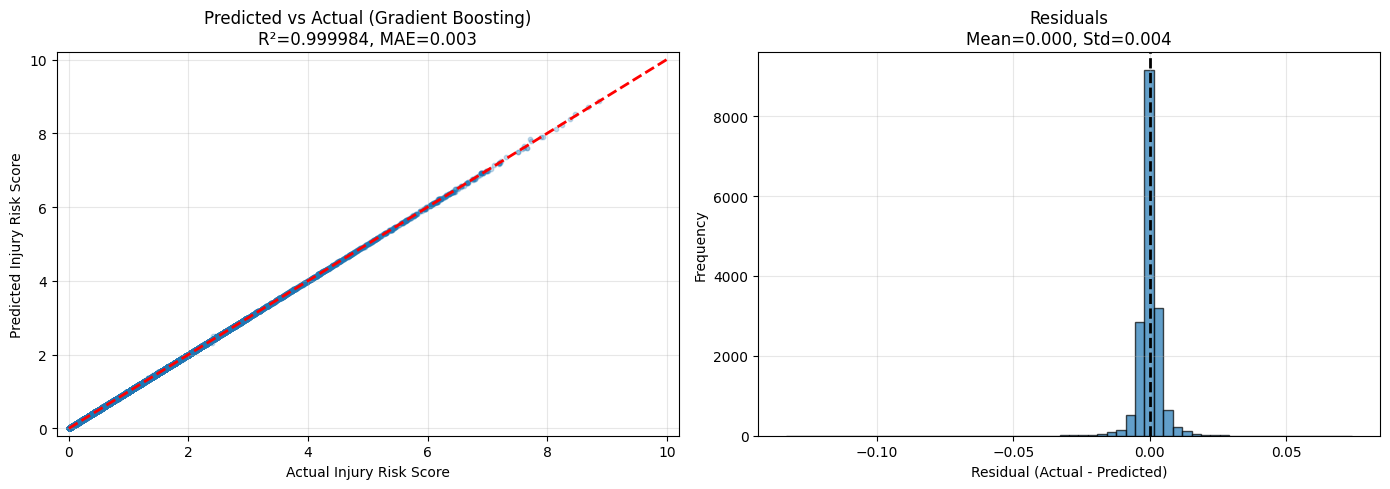

[OK] Saved: IMPETUS_B_Predictions_Residuals.png

FEATURE IMPORTANCE (Top 15):
                  Feature   Importance
                     acwr 9.999982e-01
               TSB_x_ACWR 5.637056e-07
  impulse_rolling_7d_mean 4.928641e-07
          fatigue_lag_14d 3.837286e-07
injury_risk_score_lag_14d 3.118096e-08
     acwr_rolling_7d_mean 2.905300e-08
     acwr_rolling_14d_std 2.740339e-08
        fitness_trend_14d 1.936919e-08
 injury_risk_score_lag_7d 1.908869e-08
 impulse_rolling_14d_mean 1.831905e-08
     acwr_acceleration_7d 1.586959e-08
                    tau_F 1.531017e-08
        delta_fitness_28d 1.445313e-08
      acwr_rolling_7d_std 1.420978e-08
           impulse_x_acwr 1.295272e-08



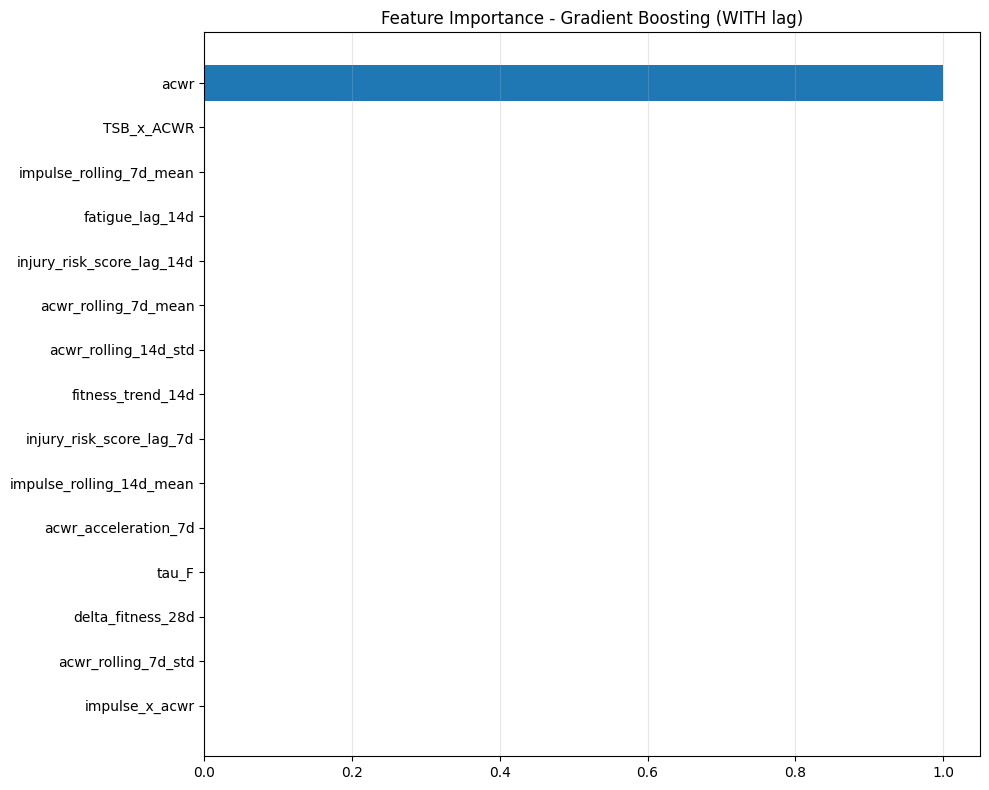

[OK] Saved: IMPETUS_B_Feature_Importance.png

[INFO] Nessun y_test==0 trovato: skip 'Preds_when_y0' plot.


In [13]:
# ============================================================================
# CELL 10: Visualizations
# ============================================================================

print("\n" + "=" * 80)
print("VISUALIZATIONS")
print("=" * 80)

# predizioni best model (WITH lag)
if best_model_name == "Ridge":
    y_test_pred_best = y_test_pred_ridge
elif best_model_name == "Decision Tree":
    y_test_pred_best = y_test_pred_dt
elif best_model_name == "Random Forest":
    y_test_pred_best = y_test_pred_rf
elif best_model_name == "Gradient Boosting":
    y_test_pred_best = y_test_pred_gb
else:
    y_test_pred_best = y_test_pred_xgb

# 1) Predicted vs Actual + residuals
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(y_test, y_test_pred_best, alpha=0.25, s=10)
axes[0].plot([0, 10], [0, 10], "r--", linewidth=2)
axes[0].set_xlabel("Actual Injury Risk Score")
axes[0].set_ylabel("Predicted Injury Risk Score")
axes[0].set_title(f"Predicted vs Actual ({best_model_name})\nR²={best_r2:.6f}, MAE={best_mae:.3f}")
axes[0].grid(alpha=0.3)
axes[0].set_xlim(-0.2, 10.2)
axes[0].set_ylim(-0.2, 10.2)

residuals = y_test - y_test_pred_best
axes[1].hist(residuals, bins=60, alpha=0.7, edgecolor="black")
axes[1].axvline(0, color="black", linestyle="--", linewidth=2)
axes[1].set_xlabel("Residual (Actual - Predicted)")
axes[1].set_ylabel("Frequency")
axes[1].set_title(f"Residuals\nMean={residuals.mean():.3f}, Std={residuals.std():.3f}")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(VIZ_DIR / "IMPETUS_B_Predictions_Residuals.png", dpi=300, bbox_inches="tight")
plt.show()
print("[OK] Saved: IMPETUS_B_Predictions_Residuals.png")
print()

# 2) Feature importance (GB/RF)
if best_model_name in ["Gradient Boosting", "Random Forest"]:
    importance = best_model_with_lag.feature_importances_
    fi = pd.DataFrame({"Feature": feature_cols, "Importance": importance}).sort_values("Importance", ascending=False)

    print("FEATURE IMPORTANCE (Top 15):")
    print(fi.head(15).to_string(index=False))
    print()

    plt.figure(figsize=(10, 8))
    top = fi.head(15).iloc[::-1]
    plt.barh(top["Feature"], top["Importance"])
    plt.title(f"Feature Importance - {best_model_name} (WITH lag)")
    plt.grid(alpha=0.3, axis="x")
    plt.tight_layout()
    plt.savefig(VIZ_DIR / "IMPETUS_B_Feature_Importance.png", dpi=300, bbox_inches="tight")
    plt.show()
    print("[OK] Saved: IMPETUS_B_Feature_Importance.png")
    print()

# 3) Distribuzione predizioni quando y=0 (se presenti)
mask_zero = (y_test == 0)
if mask_zero.any():
    plt.figure(figsize=(8, 4))
    plt.hist(y_test_pred_best[mask_zero], bins=60, alpha=0.8, edgecolor="black")
    plt.title("Predictions when Actual injury_risk_score = 0")
    plt.xlabel("Predicted risk")
    plt.ylabel("Frequency")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(VIZ_DIR / "IMPETUS_B_Preds_when_y0.png", dpi=300, bbox_inches="tight")
    plt.show()
    print("[OK] Saved: IMPETUS_B_Preds_when_y0.png")
else:
    print("[INFO] Nessun y_test==0 trovato: skip 'Preds_when_y0' plot.")


#****

In [14]:
# ============================================================================
# CELL 11: Model Save & Comparison JSON (PIPELINE B)
# ============================================================================

print("\n" + "=" * 80)
print("MODEL SAVE - PIPELINE B")
print("=" * 80)

model_path = MODEL_DIR / "impetus_model_B_with_lag.pkl"

model_package = {
    "pipeline": PIPELINE_KEY,
    "target_col": TARGET_COL,
    "model": best_model_with_lag,
    "model_name": best_model_name,
    "feature_cols": feature_cols,
    "r2_test": float(best_r2),
    "mae_test": float(best_mae),
    "train_test_gap": float(best_gap),
    "hyperparams": best_model_with_lag.get_params() if hasattr(best_model_with_lag, "get_params") else None
}

with open(model_path, "wb") as f:
    pickle.dump(model_package, f)

print(f"[OK] Model saved: {model_path} ({model_path.stat().st_size/1024:.1f} KB)")

comparison_data = {
    "pipeline": PIPELINE_KEY,
    "target_col": TARGET_COL,
    "split_strategy": metadata.get("split_strategy", None),
    "use_target_lags": metadata.get("use_target_lags", None),
    "with_lag": {
        "models": results_with_lag.to_dict("records"),
        "best_model": best_model_name,
        "r2_test": float(best_r2),
        "mae_test": float(best_mae),
        "gap": float(best_gap),
        "n_features": int(len(feature_cols))
    },
    "without_lag": {
        "results_r2_test": {k: float(v) for k, v in results_no_lag.items()},
        "best_model": best_model_name_no_lag,
        "r2_test": float(best_r2_no_lag),
        "mae_test": float(best_mae_no_lag),
        "n_features": int(len(features_no_lag))
    },
    "comparison": {
        "r2_improvement_with_lag": float(best_r2 - best_r2_no_lag),
        "n_features_removed": int(len(feature_cols) - len(features_no_lag))
    }
}

comparison_path = MODEL_DIR / "impetus_comparison_B.json"
with open(comparison_path, "w") as f:
    json.dump(comparison_data, f, indent=2)

print(f"[OK] Comparison saved: {comparison_path}")

print("\n" + "=" * 80)
print("IMPETUS MODELING B - COMPLETATO!")
print("=" * 80)
print(f"Best WITH lag   : {best_model_name} | R²={best_r2:.6f} | MAE={best_mae:.3f}")
print(f"Best WITHOUT lag: {best_model_name_no_lag} | R²={best_r2_no_lag:.6f} | MAE={best_mae_no_lag:.3f}")



MODEL SAVE - PIPELINE B
[OK] Model saved: models/impetus_model_B_with_lag.pkl (436.2 KB)
[OK] Comparison saved: models/impetus_comparison_B.json

IMPETUS MODELING B - COMPLETATO!
Best WITH lag   : Gradient Boosting | R²=0.999984 | MAE=0.003
Best WITHOUT lag: Gradient Boosting | R²=0.999983 | MAE=0.003


In [15]:
# ============================================================================
# FINAL CHECKS: ACWR dominance
# ============================================================================

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

def eval_reg(y_true, y_pred, label):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{label:>20s} | R2={r2:.6f} | MAE={mae:.6f} | RMSE={rmse:.6f}")
    return r2, mae, rmse

feat_acwr = ["acwr"]
Xtr1 = train_df[feat_acwr]
Xte1 = test_df[feat_acwr]

print("\n" + "="*80)
print("SANITY CHECK: ACWR-ONLY vs FULL")
print("="*80)

# ACWR-only DT
dt_acwr = DecisionTreeRegressor(max_depth=10, min_samples_split=50, random_state=42)
dt_acwr.fit(Xtr1, y_train)
pred_dt_acwr = dt_acwr.predict(Xte1)
r2_dt_acwr, mae_dt_acwr, rmse_dt_acwr = eval_reg(y_test, pred_dt_acwr, "ACWR-only DT")

# ACWR-only GB
gb_acwr = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=3, random_state=42)
gb_acwr.fit(Xtr1, y_train)
pred_gb_acwr = gb_acwr.predict(Xte1)
r2_gb_acwr, mae_gb_acwr, rmse_gb_acwr = eval_reg(y_test, pred_gb_acwr, "ACWR-only GB")

# Full best model
print(f"{'FULL best':>20s} | R2={best_r2:.6f} | MAE={best_mae:.6f} | RMSE=NA")
print()



SANITY CHECK: ACWR-ONLY vs FULL
        ACWR-only DT | R2=0.999622 | MAE=0.004631 | RMSE=0.021593
        ACWR-only GB | R2=0.999968 | MAE=0.004067 | RMSE=0.006244
           FULL best | R2=0.999984 | MAE=0.002536 | RMSE=NA



In [16]:
# ============================================================================
# SAVE ARTIFACTS: full model + compact ACWR-only model
# ============================================================================

MODEL_DIR.mkdir(exist_ok=True)

# --- 1) FULL model (already selected as best_model_with_lag) ---
full_path = MODEL_DIR / "impetus_model_B_full.pkl"

full_package = {
    "pipeline": PIPELINE_KEY,
    "target_col": TARGET_COL,
    "model_name": best_model_name,
    "model": best_model_with_lag,
    "feature_cols": feature_cols,
    "metrics": {
        "r2_test": float(best_r2),
        "mae_test": float(best_mae),
        "gap": float(best_gap),
    }
}

with open(full_path, "wb") as f:
    pickle.dump(full_package, f)

print(f"[OK] Saved FULL model -> {full_path} ({full_path.stat().st_size/1024:.1f} KB)")


# --- 2) COMPACT demo model (ACWR-only DT) ---
compact_path = MODEL_DIR / "impetus_model_B_compact_acwr_dt.pkl"

compact_features = ["acwr"]
compact_model = DecisionTreeRegressor(max_depth=10, min_samples_split=50, random_state=42)
compact_model.fit(train_df[compact_features], y_train)

pred_compact = compact_model.predict(test_df[compact_features])
r2_compact = r2_score(y_test, pred_compact)
mae_compact = mean_absolute_error(y_test, pred_compact)
rmse_compact = np.sqrt(mean_squared_error(y_test, pred_compact))

compact_package = {
    "pipeline": PIPELINE_KEY,
    "target_col": TARGET_COL,
    "model_name": "DecisionTreeRegressor_ACWR_only",
    "model": compact_model,
    "feature_cols": compact_features,
    "metrics": {
        "r2_test": float(r2_compact),
        "mae_test": float(mae_compact),
        "rmse_test": float(rmse_compact),
    }
}

with open(compact_path, "wb") as f:
    pickle.dump(compact_package, f)

print(f"[OK] Saved COMPACT model -> {compact_path} ({compact_path.stat().st_size/1024:.1f} KB)")
print(f"     Compact metrics: R2={r2_compact:.6f} | MAE={mae_compact:.6f} | RMSE={rmse_compact:.6f}")
print()


[OK] Saved FULL model -> models/impetus_model_B_full.pkl (436.1 KB)
[OK] Saved COMPACT model -> models/impetus_model_B_compact_acwr_dt.pkl (113.1 KB)
     Compact metrics: R2=0.999622 | MAE=0.004631 | RMSE=0.021593



In [17]:
# ============================================================================
# DEMO CONTRACT: helper predict() with safety checks
# ============================================================================

def predict_injury_risk_from_row(row_like, model_package):
    feats = model_package["feature_cols"]
    X = pd.DataFrame([row_like], columns=feats)
    return float(model_package["model"].predict(X)[0])

# quick test with a real test row
with open(MODEL_DIR / "impetus_model_B_compact_acwr_dt.pkl", "rb") as f:
    pkg = pickle.load(f)

sample_row = {"acwr": float(test_df.iloc[0]["acwr"])}
pred = predict_injury_risk_from_row(sample_row, pkg)
print("Demo predict OK. Example pred =", pred)


Demo predict OK. Example pred = 2.452238318632191
